In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import numpy as np
import xgboost, numpy, textblob, string

C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\Image.py:82: RuntimeWarning: The _imaging extension was built for another version of Pillow or PIL:
Core version: 5.3.0
Pillow version: 5.1.0
  warnings.warn(str(v), RuntimeWarning)


## Read data

In [49]:
data = pd.read_csv("data/data_ALL.csv")

In [3]:
data = pd.read_csv("data/data_ALL_filtered.csv")

In [71]:
# cols = ['website', 'mcc', 'content', 'cluster', 'index1']
# data_ALL = data_ALL[cols]

In [191]:
data_new = pd.read_csv("data/data_electronics.csv")

In [192]:
data = data_ALL.append(data_new, ignore_index = True)

### Filter unknown

In [51]:
data = data[data.cluster != "unknown"]

### Filter inadequate data

In [12]:
def inadequate_data(content):
    if len(str(content).split(" ")) > 20:
        return content
    else:
        return "None"
    
data["content"] = data["content"].apply(inadequate_data)
data = data[data.content != "None"]

In [13]:
data = data.reset_index(drop=True)
data['index1'] = data.index

In [4]:
len(data)

950

In [16]:
data.to_csv("data/data_ALL_filtered.csv", encoding='utf-8', index=False)

## Split into train & test

In [5]:
train_x_idx, valid_x_idx, train_y, valid_y = model_selection.train_test_split(data['index1'], data['cluster'])
train_x = data.content[train_x_idx]
valid_x = data.content[valid_x_idx]

### Create count vectorizer

In [7]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(data['content'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

### Get tfidf & ngrams

In [8]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(data['content'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2), max_features=5000)
tfidf_vect_ngram.fit(data['content'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

### train function

In [9]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    print(metrics.accuracy_score(predictions, valid_y))
    return predictions


In [10]:
# Linear Classifier on Ngram Level TF IDF Vectors
predictions = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)


C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7899159663865546


In [14]:
# SVM on Ngram Level TF IDF Vectors
svclassifier = SVC(kernel='linear')  
predictions = train_model(svclassifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y)

#accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)

C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6049382716049383


In [15]:
predictions = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)

0.654320987654321


C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [11]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
#print ("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
#print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
#print("NB, N-Gram Vectors: ", accuracy)


0.592436974789916
0.6050420168067226
0.5588235294117647


In [ ]:
# Linear Classifier on Count Vectors
predictions = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
#print("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
predictions = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
#print("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
#print("LR, N-Gram Vectors: ", accuracy)



C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [15]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
#print("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
#print("RF, WordLevel TF-IDF: ", accuracy)

C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5596707818930041
0.6460905349794238


C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [16]:
# Extereme Gradient Boosting on Count Vectors
predictions = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
#print("Xgb, Count Vectors: ", accuracy)


0.757201646090535


In [17]:
# Extereme Gradient Boosting on Word Level TF IDF Vectors
predictions = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
#print("Xgb, WordLevel TF-IDF: ", accuracy)

0.7901234567901234


In [18]:
# Extereme Gradient Boosting on ngram Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram.tocsc(), train_y, xvalid_tfidf_ngram.tocsc())
#print("Xgb, CharLevel Vectors: ", accuracy)

0.7901234567901234


In [18]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(valid_y, predictions)
class_names = list(data.cluster)

Confusion matrix, without normalization


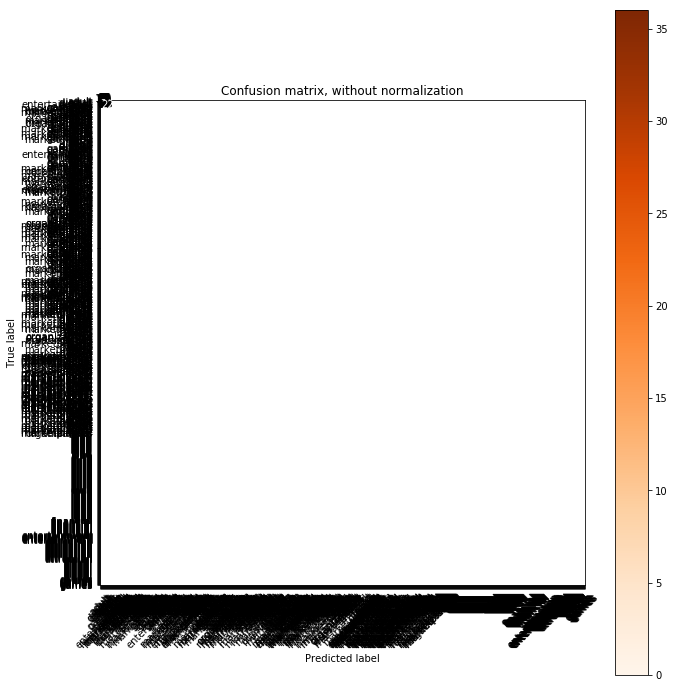

In [20]:
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(valid_y, predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plt.figure()
plt.figure(figsize = (10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()
plt.savefig('books_read.png')

In [25]:
i = 0
for idx in valid_x_idx:
    if data.cluster[idx] != predictions[i]:
        print(data.website[idx])
        print("True: ", data.cluster[idx])
        print("Predicted: ", predictions[i])
    i = i+1

http://www.newzoo.com
True:  read
Predicted:  games
http://www.lovers.nl
True:  entertainment
Predicted:  attraction
https://www.psychicguild.com/fortune-telling/
True:  attraction
Predicted:  adult
http://www.rotown.nl
True:  entertainment
Predicted:  attraction
http://www.eleqt.com
True:  digital 
Predicted:  adult
http://www.liveliteintl.com
True:  marketplace2
Predicted:  adult
http://www.dressonlinemall.com
True:  outfit
Predicted:  adult
http://www.ddtank.us
True:  games
Predicted:  read
http://www.devillefashion.be
True:  outfit
Predicted:  adult
http://www.gtbill.com
True:  adult
Predicted:  financial
http://www.fireflycarrental.com/rentalcar/reservation/home
True:  auto
Predicted:  travel
http://www.i-reel.com
True:  digital 
Predicted:  travel
http://www.foreverliving.com
True:  marketplace2
Predicted:  travel
http://advanceddermatology.com
True:  marketplace1 
Predicted:  marketplace2
https://tuneintunes.com/
True:  entertainment
Predicted:  adult
http://www.mesalabs.com
Tru

In [195]:
data.to_csv("data/data_ALL.csv", encoding='utf-8', index=False)

In [15]:
#set(data[data["cluster"] == "marketplace1"].mcc)

{5021,
 5065,
 5072,
 5111,
 5198,
 5200,
 5251,
 5300,
 5331,
 5399,
 5712,
 5714,
 5719,
 5722,
 5941,
 5947,
 5948,
 5968,
 5995,
 5999,
 7629}

In [28]:
data[data["mcc"] == 7629].website

458    http://www.applianceserve.co.uk
Name: website, dtype: object

In [21]:
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[1]), range(cm.shape[0])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(valid_y, predictions, labels = class_names)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plt.figure()
plt.figure(figsize = (10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization


KeyboardInterrupt: 

In [23]:
from sklearn.metrics import confusion_matrix

class_names = list(set(data.cluster))

cnf_matrix = confusion_matrix(valid_y, predictions, labels = class_names)


Confusion matrix, without normalization


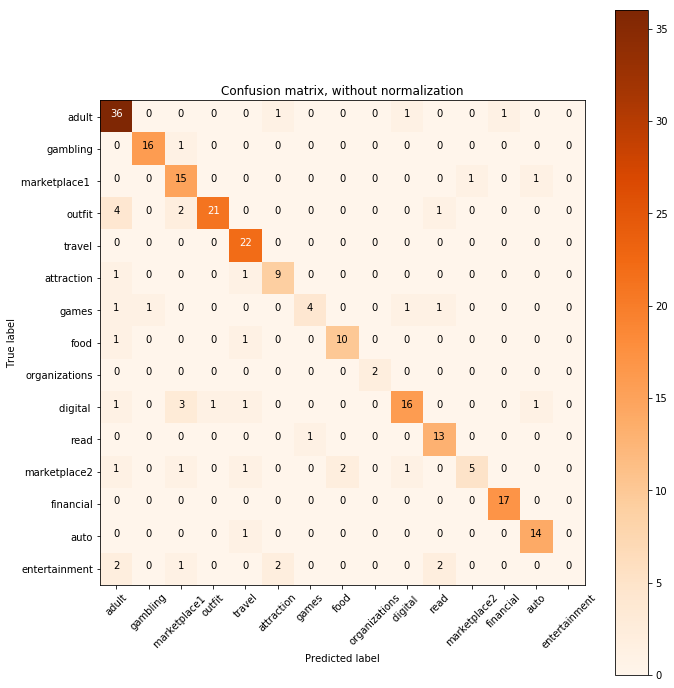

In [24]:
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[1]), range(cm.shape[0])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(valid_y, predictions, labels = class_names)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plt.figure()
plt.figure(figsize = (10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [47]:
set(data.cluster)

{'adult',
 'attraction',
 'auto',
 'digital ',
 'entertainment',
 'financial',
 'food',
 'food ',
 'gambling',
 'games',
 'marketplace1 ',
 'marketplace2',
 'outfit',
 'read',
 'travel'}

In [1]:
valid_y

NameError: name 'valid_y' is not defined